In [1]:
import os
import glob

import numpy as  np
import pandas as pd
import pylab as plt

from scipy.signal import medfilt, butter, filtfilt
from scipy.stats import linregress
from scipy.optimize import curve_fit, minimize

In [16]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
For photometry data pre-processing
Modified from pyPhotometry pre-processing (by Akam)
For 4-Fiber brances
Column# in CSV Data
Loc0:3 -> 8
Loc1:4 -> 9
Loc2:5 -> 10
Loc3:6 -> 11
______________
22061x-
8,9,10,11
Started on Fri Mar  4 01:58:25 2022
@author: Kenta M. Hagihara @SvobodaLab
"""

'\nFor photometry data pre-processing\nModified from pyPhotometry pre-processing (by Akam)\nFor 4-Fiber brances\nColumn# in CSV Data\nLoc0:3 -> 8\nLoc1:4 -> 9\nLoc2:5 -> 10\nLoc3:6 -> 11\n______________\n22061x-\n8,9,10,11\nStarted on Fri Mar  4 01:58:25 2022\n@author: Kenta M. Hagihara @SvobodaLab\n'

In [5]:
# load data
DATA_ROOT_DIR = '/home/map/map-ephys/data/nm_data'
ANA_DIR = 'testdata_photometry_0727/'
ana_dir_path = os.path.join(DATA_ROOT_DIR, ANA_DIR)

RES_DIR = 'result'
result_dir = os.path.join(ana_dir_path, RES_DIR)
if not os.path.isdir(result_dir):
    print(f'creating result directory: {result_dir}')
    os.mkdir(result_dir)
else:
    print(f'result directory existed: {result_dir}')

result directory existed: /home/map/map-ephys/data/nm_data/testdata_photometry_0727/result


In [18]:
# load file
'''
def load_csv(filepath):
    import csv
    with open(filepath) as f:
        reader = csv.reader(f)
        datatemp = np.array([row for row in reader])
        data = datatemp[1:,:].astype(np.float32)
        print('{}: {}'.format(filepath, data.shape))
        return data

file_1  = glob.glob(os.path.join(ana_dir_path, "L415*"))[0]
file_2  = glob.glob(os.path.join(ana_dir_path, "L470*"))[0]
file_3  = glob.glob(os.path.join(ana_dir_path, "L560*"))[0]

data_1 = load_csv(file_1)
data_2 = load_csv(file_2)
data_3 = load_csv(file_3)

# in case acquisition halted accidentally
length = np.amin([len(data_1),len(data_2),len(data_3)])
data_1 = data_1[0:length]
data_2 = data_2[0:length]
data_3 = data_3[0:length]
'''

filenames = ['L415', 'L470', 'L560']
filepaths = [
    glob.glob(os.path.join(ana_dir_path, fn+'*'))[0] for fn in filenames]
dfs = [
    pd.read_csv(fp) for fp in filepaths]

print('raw data read:')
for i, df in enumerate(dfs):
    print('{}: {}'.format(i, df.shape))
    # print(df.head())

# in case of acquisition halted accidentally
print('adjust for minimal length:')
length = np.min([len(df) for df in dfs])
dfs = [df[:length] for df in dfs]
for i, df in enumerate(dfs):
    print('{}: {}'.format(i, df.shape))
    # print(df.head())

raw data read:
0: (117681, 12)
1: (117681, 12)
2: (117680, 12)
adjust for minimal length:
0: (117680, 12)
1: (117680, 12)
2: (117680, 12)


In [19]:
# check data frame
print(dfs[0].columns)

Index(['FrameCounter', 'Timestamp', 'LedState', 'Stimulation', 'Output0',
       'Output1', 'Input0', 'Input1', 'Region0G', 'Region1G', 'Region2R',
       'Region3R'],
      dtype='object')


In [20]:
# exp parameters
n_fibers = 2
n_color = 3
sampling_rate = 20.0   # individual channel (not total)
n_frame2cut = 100    # crop initial n frames
b_percentile = 0.70  # To calculare F0, median of bottom x%

# ?
#BiExpFitIni = [1,1e-3,5,1e-3,5]
BiExpFitIni = [1,1e-3,1,1e-3,1]  #currently not used


In [21]:
# deprecated
'''
#%% Data sort # 1,2:Time-Frame info; ROI0:3;ROI1:4,ROI2:5,ROI3:6;...
#Data_Fiber1iso = data1[:,3]
#Data_Fiber1G = data2[:,3]
#Data_Fiber1R = data3[:,5]
 
#Data_Fiber2iso = data1[:,4]
##Data_Fiber2G = data2[:,4]
Data_Fiber2R = data3[:,6]
#%% from 220609-, ROI0:8;ROI1:9,ROI2:10,ROI3:11;
Data_Fiber1iso = data1[:,8]
Data_Fiber1G = data2[:,8]
Data_Fiber1R = data3[:,10]
 
Data_Fiber2iso = data1[:,9]
Data_Fiber2G = data2[:,9]
Data_Fiber2R = data3[:,11]


#%% From here to be multiplexed
'''

'\n#%% Data sort # 1,2:Time-Frame info; ROI0:3;ROI1:4,ROI2:5,ROI3:6;...\n#Data_Fiber1iso = data1[:,3]\n#Data_Fiber1G = data2[:,3]\n#Data_Fiber1R = data3[:,5]\n \n#Data_Fiber2iso = data1[:,4]\n##Data_Fiber2G = data2[:,4]\nData_Fiber2R = data3[:,6]\n#%% from 220609-, ROI0:8;ROI1:9,ROI2:10,ROI3:11;\nData_Fiber1iso = data1[:,8]\nData_Fiber1G = data2[:,8]\nData_Fiber1R = data3[:,10]\n \nData_Fiber2iso = data1[:,9]\nData_Fiber2G = data2[:,9]\nData_Fiber2R = data3[:,11]\n\n\n#%% From here to be multiplexed\n'

In [22]:
# extract nm traces
fiber1_iso = dfs[0]['Region0G'].values
fiber1_G = dfs[1]['Region0G'].values
fiber1_R = dfs[2]['Region2R'].values

fiber2_iso = dfs[0]['Region1G'].values
fiber2_G = dfs[1]['Region1G'].values
fiber2_R = dfs[2]['Region3R'].values

G1_raw = fiber1_G[n_frame2cut:]
G2_raw = fiber2_G[n_frame2cut:]
R1_raw = fiber1_R[n_frame2cut:]
R2_raw = fiber2_R[n_frame2cut:]
ctrl1_raw = fiber1_iso[n_frame2cut:]
ctrl2_raw = fiber2_iso[n_frame2cut:]

time_seconds = np.arange(len(G1_raw)) / sampling_rate

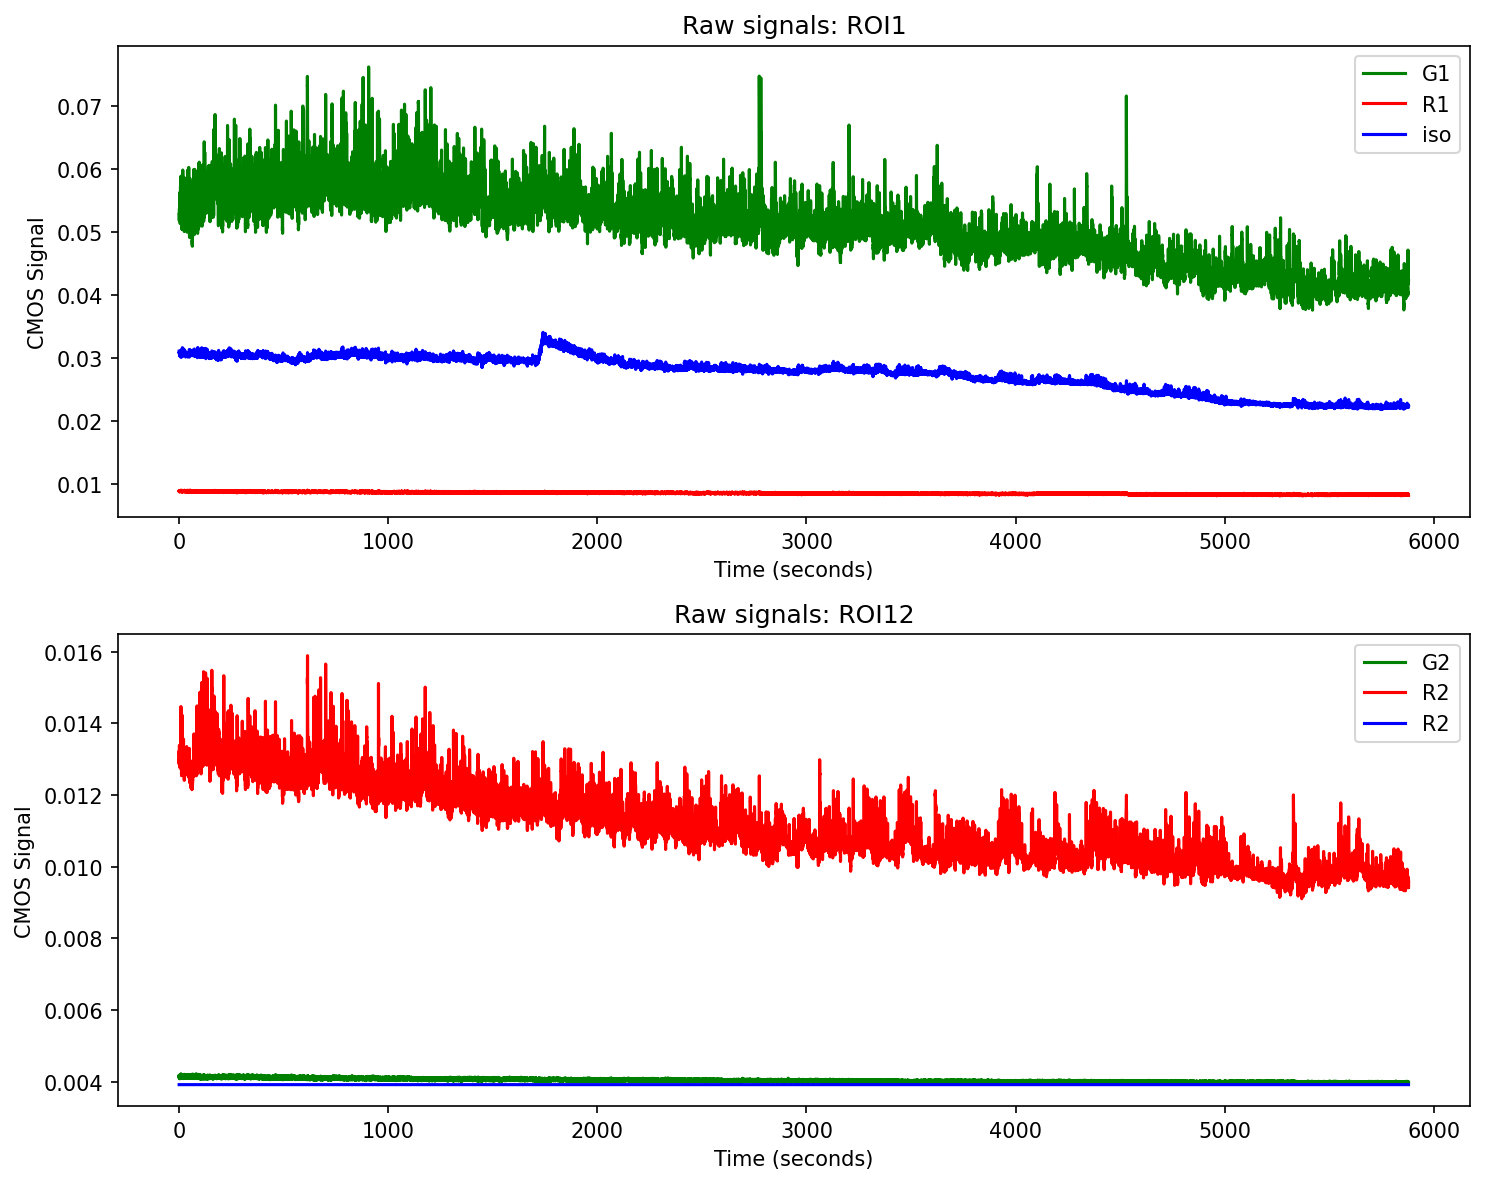

In [23]:
# Raw signals
plt.figure(figsize=(10, 8), dpi=150)
plt.subplot(2,1,1)
plt.plot(time_seconds, G1_raw, 'g', label='G1')
plt.plot(time_seconds, R1_raw, 'r', label='R1')
plt.plot(time_seconds, ctrl1_raw, 'b', label='iso')
plt.xlabel('Time (seconds)')
plt.ylabel('CMOS Signal')
plt.title('Raw signals: ROI1')
plt.legend()

plt.subplot(2,1,2)
plt.plot(time_seconds, G2_raw, 'g', label='G2')
plt.plot(time_seconds, R2_raw, 'r', label='R2')
plt.plot(time_seconds, ctrl2_raw, 'b', label='R2')
plt.xlabel('Time (seconds)')
plt.ylabel('CMOS Signal')
plt.title('Raw signals: ROI12')
plt.tight_layout()
plt.legend()

In [ ]:
# pre-process steps
# median filtering and low pass filtering
# poly fit (4th-degree) subtraction
# motion correction using linear regression
# dF/F calculation

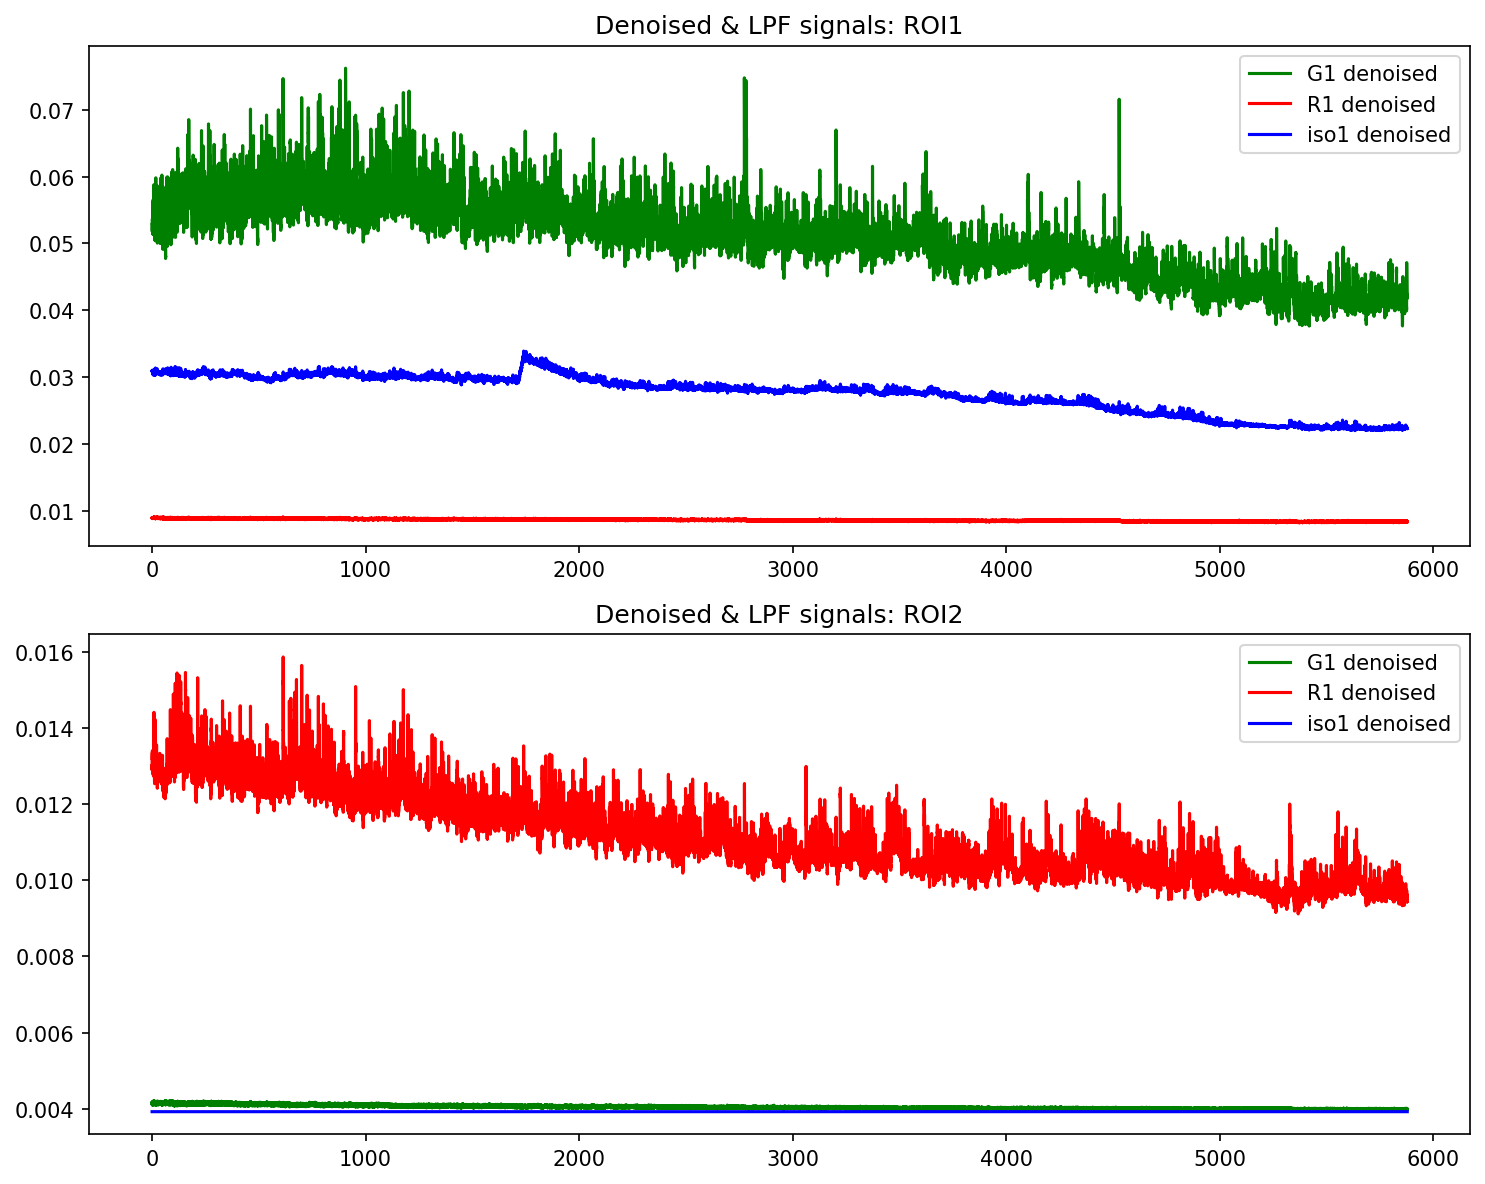

In [24]:
# Median filtering to remove electrical artifact.
kernel_size = 1
G1_denoised = medfilt(G1_raw, kernel_size=kernel_size)
G2_denoised = medfilt(G2_raw, kernel_size=kernel_size)
R1_denoised = medfilt(R1_raw, kernel_size=kernel_size)
R2_denoised = medfilt(R2_raw, kernel_size=kernel_size)
ctrl1_denoised = medfilt(ctrl1_raw, kernel_size=5)
ctrl2_denoised = medfilt(ctrl2_raw, kernel_size=5)
 
# Low pass filter
# zero phase filtering (with filtfilt) is used to avoid distorting the signal.
b, a = butter(2, 9, btype='low', fs=sampling_rate)
G1_denoised = filtfilt(b, a, G1_denoised)
G2_denoised = filtfilt(b, a, G2_denoised)
R1_denoised = filtfilt(b, a, R1_denoised)
R2_denoised = filtfilt(b, a, R2_denoised)
ctrl1_denoised = filtfilt(b, a, ctrl1_denoised)
ctrl2_denoised = filtfilt(b, a, ctrl2_denoised)

# median filtering & low pass filter
plt.figure(figsize=(10, 8), dpi=150)
plt.subplot(2,1,1)
plt.plot(time_seconds, G1_denoised, 'g', label='G1 denoised')
plt.plot(time_seconds, R1_denoised, 'r', label='R1 denoised')
plt.plot(time_seconds, ctrl1_denoised, 'b', label='iso1 denoised') 
plt.title('Denoised & LPF signals: ROI1')
plt.legend()

plt.subplot(2,1,2)
plt.plot(time_seconds, G2_denoised, 'g', label='G1 denoised')
plt.plot(time_seconds, R2_denoised, 'r', label='R1 denoised')
plt.plot(time_seconds, ctrl2_denoised, 'b', label='iso1 denoised') 
plt.title('Denoised & LPF signals: ROI2')
plt.tight_layout()
plt.legend()

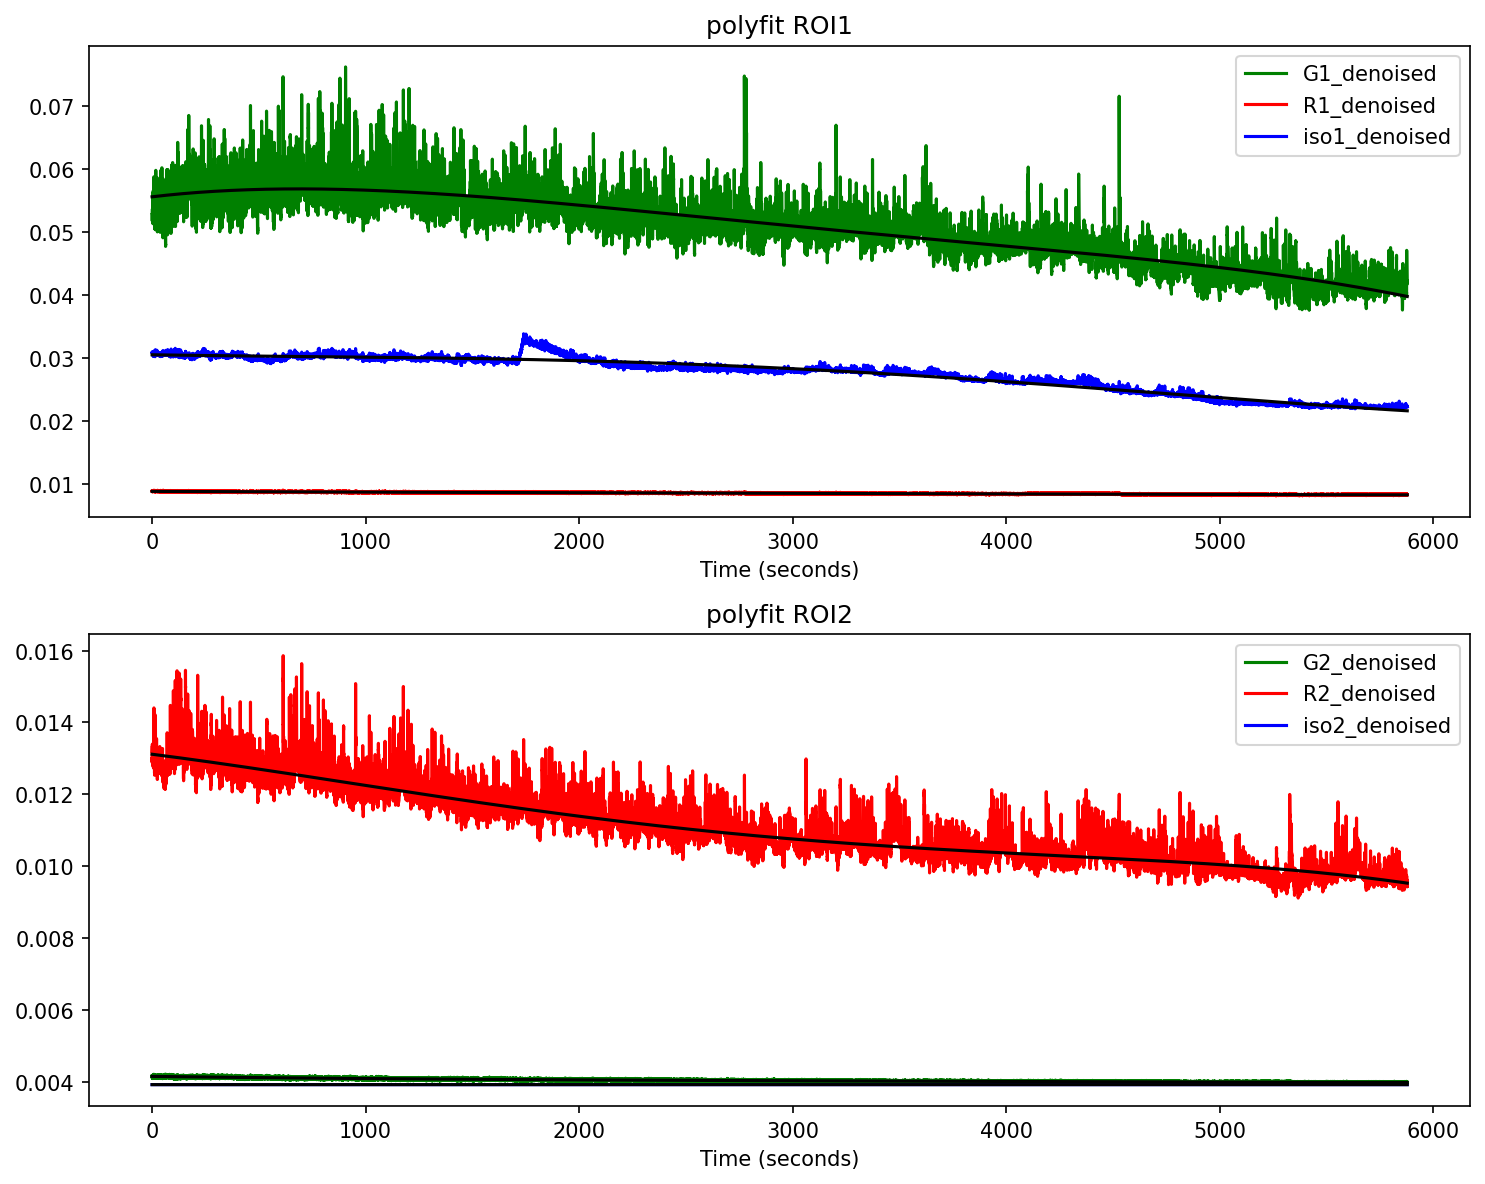

In [30]:
# poly fit adjust
# Fit 4th order polynomial to signals.
coefs_G1 = np.polyfit(time_seconds, G1_denoised, deg=4)
G1_polyfit = np.polyval(coefs_G1, time_seconds)
coefs_G2 = np.polyfit(time_seconds, G2_denoised, deg=4)
G2_polyfit = np.polyval(coefs_G2, time_seconds)
coefs_R1 = np.polyfit(time_seconds, R1_denoised, deg=4)
R1_polyfit = np.polyval(coefs_R1, time_seconds)
coefs_R2 = np.polyfit(time_seconds, R2_denoised, deg=4)
R2_polyfit = np.polyval(coefs_R2, time_seconds)
# Fit 4th order polynomial to Ctrl.
coefs_ctrl1 = np.polyfit(time_seconds, ctrl1_denoised, deg=4)
ctrl1_polyfit = np.polyval(coefs_ctrl1, time_seconds)
coefs_ctrl2 = np.polyfit(time_seconds, ctrl2_denoised, deg=4)
ctrl2_polyfit = np.polyval(coefs_ctrl2, time_seconds)

# Plot fits
plt.figure(figsize=(10, 8), dpi=150)
plt.subplot(2,1,1)
plt.plot(time_seconds, G1_denoised, 'g', label='G1_denoised')
plt.plot(time_seconds, R1_denoised, 'r', label='R1_denoised')
plt.plot(time_seconds, ctrl1_denoised, 'b', label='iso1_denoised')
plt.plot(time_seconds, G1_polyfit, 'k', linewidth=1.5) 
plt.plot(time_seconds, R1_polyfit, 'k', linewidth=1.5) 
plt.plot(time_seconds, ctrl1_polyfit, 'k', linewidth=1.5) 
plt.title('polyfit ROI1')
plt.xlabel('Time (seconds)')
plt.legend()

plt.subplot(2,1,2)
plt.plot(time_seconds, G2_denoised, 'g', label='G2_denoised')
plt.plot(time_seconds, R2_denoised, 'r', label='R2_denoised')
plt.plot(time_seconds, ctrl2_denoised, 'b', label='iso2_denoised')
plt.plot(time_seconds, G2_polyfit, 'k', linewidth=1.5) 
plt.plot(time_seconds, R2_polyfit, 'k', linewidth=1.5) 
plt.plot(time_seconds, ctrl2_polyfit, 'k', linewidth=1.5) 
plt.title('polyfit ROI2')
plt.xlabel('Time (seconds)')
plt.tight_layout()
plt.legend()

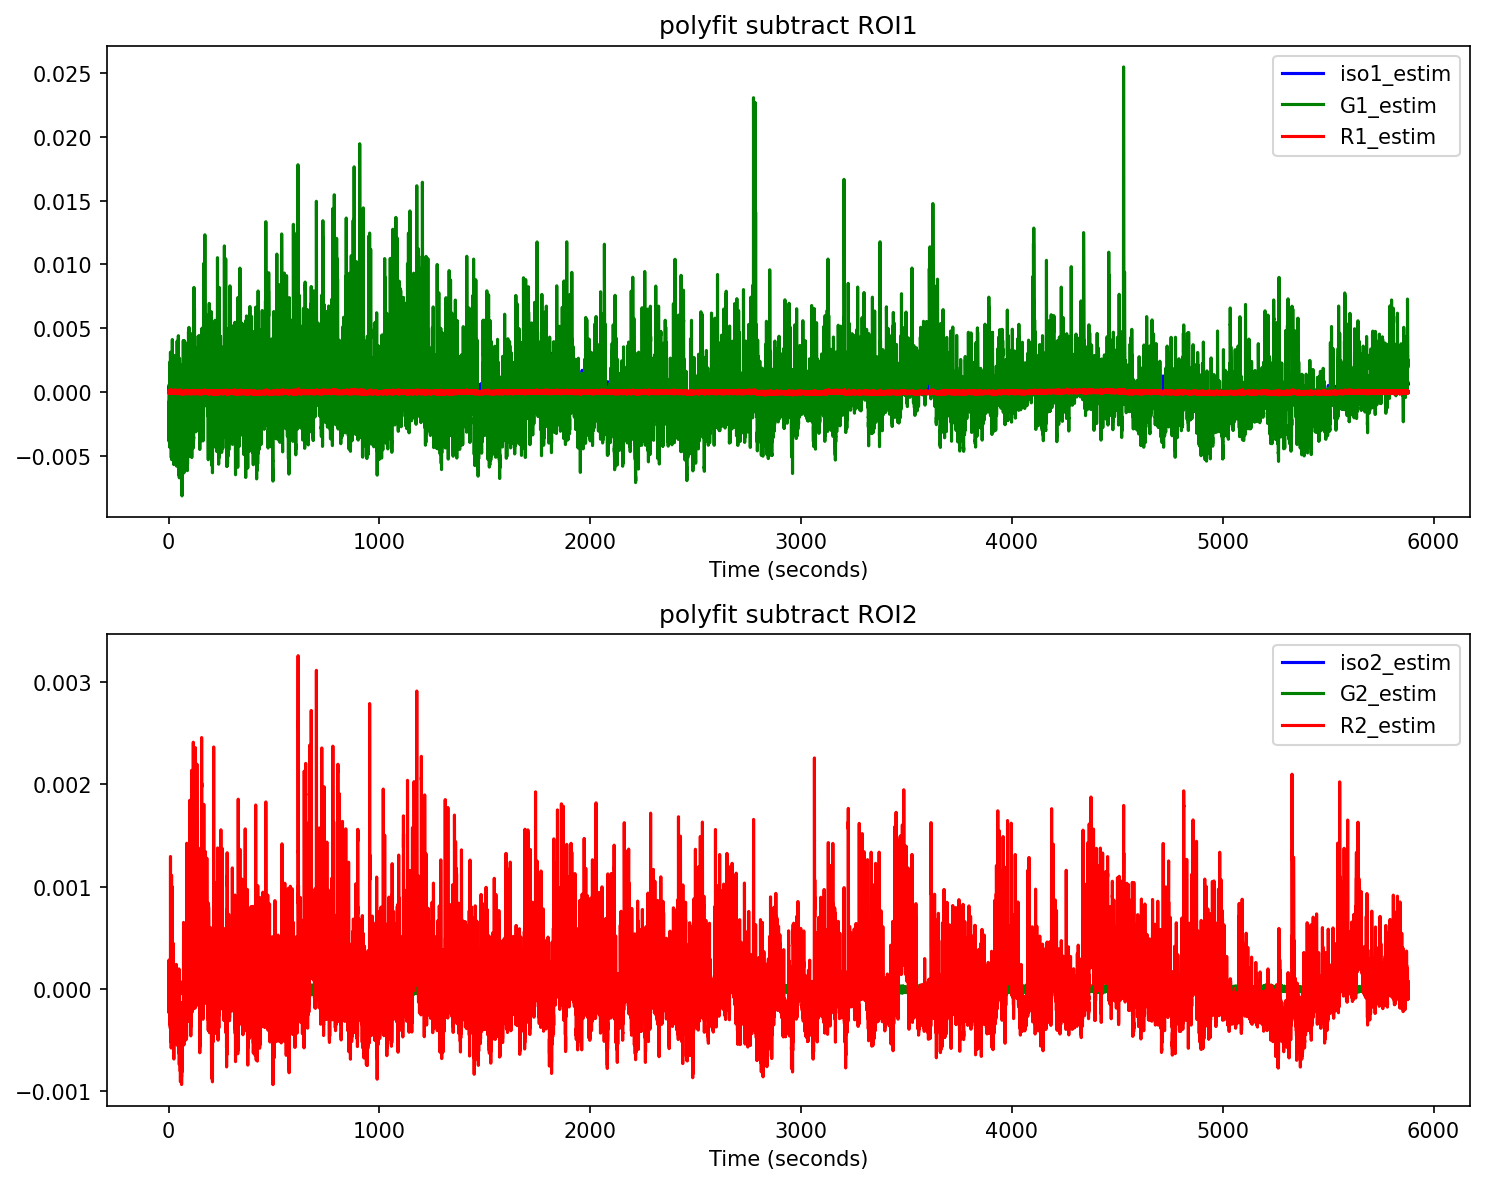

In [31]:
# subtract from polyfit
G1_es = G1_denoised - G1_polyfit
G2_es = G2_denoised - G2_polyfit
R1_es = R1_denoised - R1_polyfit
R2_es = R2_denoised - R2_polyfit
ctrl1_es = ctrl1_denoised - ctrl1_polyfit
ctrl2_es = ctrl2_denoised - ctrl2_polyfit

plt.figure(figsize=(10, 8), dpi=150)
plt.subplot(2,1,1)
plt.plot(time_seconds, ctrl1_es, 'b', label='iso1_estim')
plt.plot(time_seconds, G1_es, 'g', label='G1_estim')
plt.plot(time_seconds, R1_es, 'r', label='R1_estim')
plt.title('polyfit subtract ROI1')
plt.xlabel('Time (seconds)')
plt.legend()

plt.subplot(2,1,2)
plt.plot(time_seconds, ctrl2_es, 'b', label='iso2_estim')
plt.plot(time_seconds, G2_es, 'g', label='G2_estim')
plt.plot(time_seconds, R2_es, 'r', label='R2_estim')
plt.title('polyfit subtract ROI2')
plt.xlabel('Time (seconds)')
plt.tight_layout()
plt.legend()

Slope G1    : 0.795
R-squared G1: 0.033
Slope G2    : 20885583839.071
R-squared G2: 0.000
Slope R1    : 0.021
R-squared R1: 0.057
Slope R2    : -457625218550.890
R-squared R2: 0.000


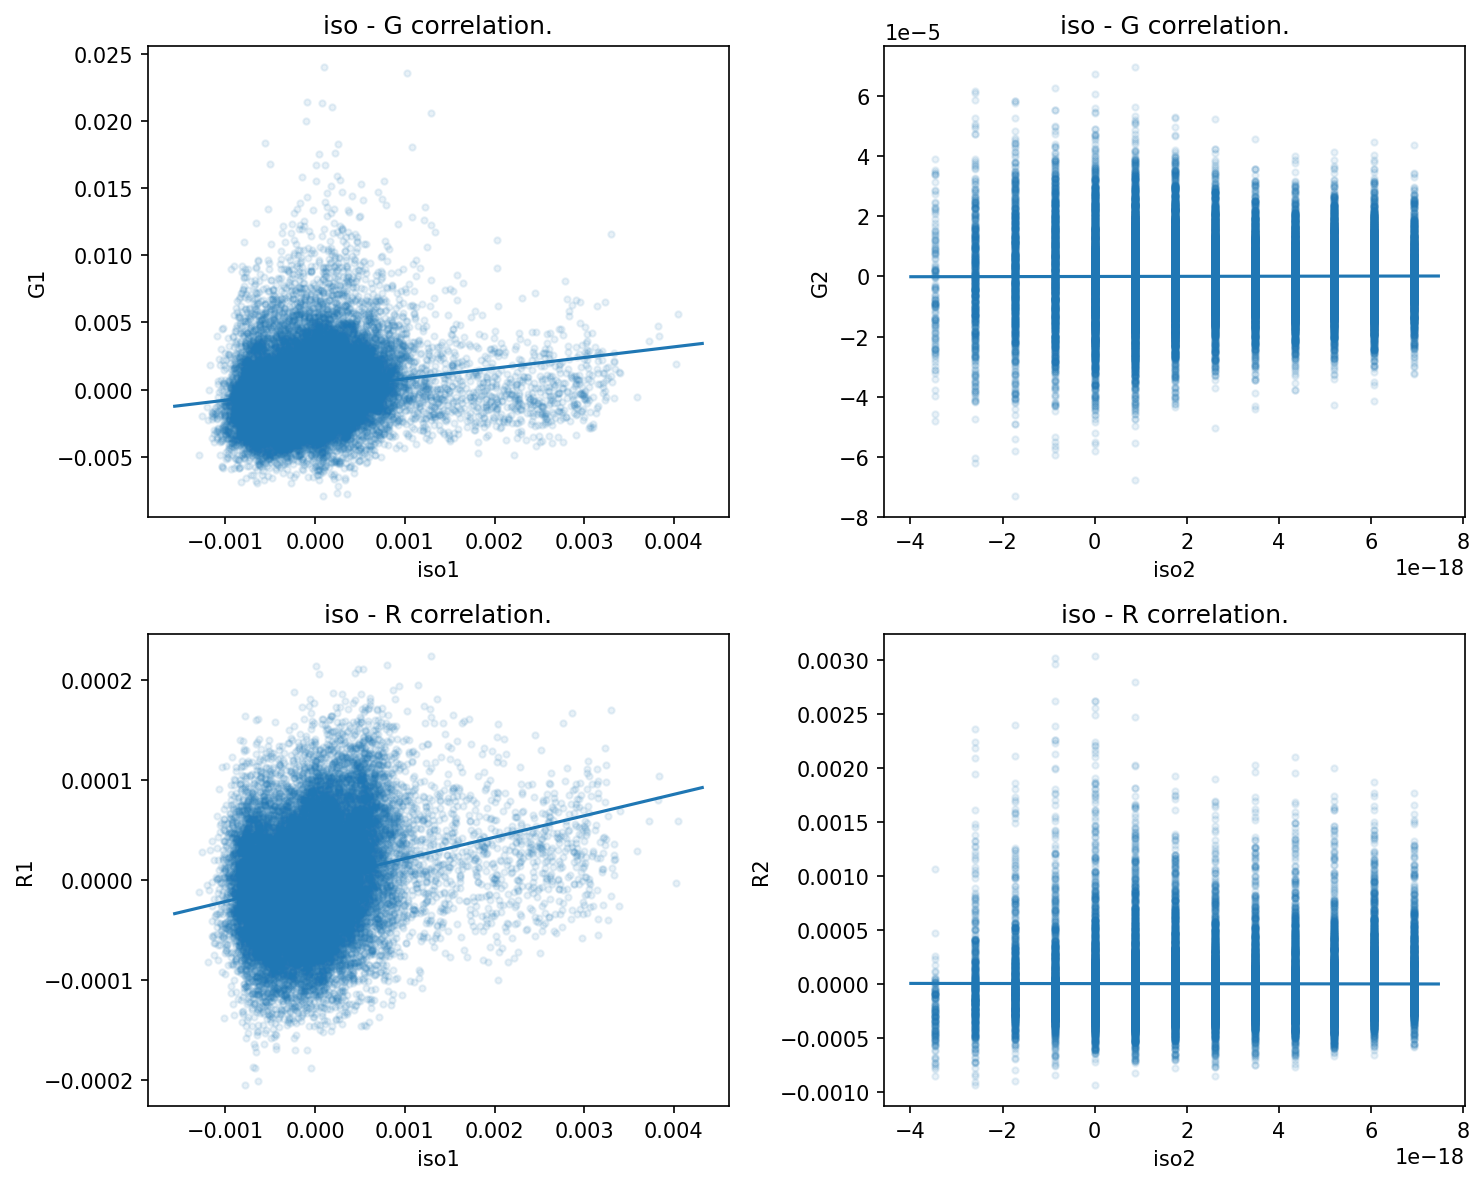

In [33]:
#%% Motion correction using iso
slope_G1, intercept_G1, r_value_G1, p_value_G1, std_err_G1 = linregress(x=ctrl1_es, y=G1_es)
slope_G2, intercept_G2, r_value_G2, p_value_G2, std_err_G2 = linregress(x=ctrl2_es, y=G2_es)
slope_R1, intercept_R1, r_value_R1, p_value_R1, std_err_R1 = linregress(x=ctrl1_es, y=R1_es)
slope_R2, intercept_R2, r_value_R2, p_value_R2, std_err_R2 = linregress(x=ctrl2_es, y=R2_es)

plt.figure(figsize=(10, 8), dpi=150)
plt.subplot(2,2,1)
plt.scatter(ctrl1_es[::5], G1_es[::5], alpha=0.1, marker='.')
x = np.array(plt.xlim())
plt.plot(x, intercept_G1+slope_G1*x)
plt.xlabel('iso1')
plt.ylabel('G1')
plt.title('iso - G correlation.')

plt.subplot(2,2,2)
plt.scatter(ctrl2_es[::5], G2_es[::5], alpha=0.1, marker='.')   # correction from Kenta's code
x = np.array(plt.xlim())
plt.plot(x, intercept_G2+slope_G2*x)
plt.xlabel('iso2')
plt.ylabel('G2')
plt.title('iso - G correlation.')

plt.subplot(2,2,3)
plt.scatter(ctrl1_es[::5], R1_es[::5], alpha=0.1, marker='.')
x = np.array(plt.xlim())
plt.plot(x, intercept_R1+slope_R1*x)
plt.xlabel('iso1')
plt.ylabel('R1')
plt.title('iso - R correlation.')

plt.subplot(2,2,4)
plt.scatter(ctrl2_es[::5], R2_es[::5],alpha=0.1, marker='.')
x = np.array(plt.xlim())
plt.plot(x, intercept_R2+slope_R2*x)
plt.xlabel('iso2')
plt.ylabel('R2')
plt.title('iso - R correlation.')
plt.tight_layout()

print('Slope G1    : {:.3f}'.format(slope_G1))
print('R-squared G1: {:.3f}'.format(r_value_G1**2))
print('Slope G2    : {:.3f}'.format(slope_G2))
print('R-squared G2: {:.3f}'.format(r_value_G2**2))

print('Slope R1    : {:.3f}'.format(slope_R1))
print('R-squared R1: {:.3f}'.format(r_value_R1**2))
print('Slope R2    : {:.3f}'.format(slope_R2))
print('R-squared R2: {:.3f}'.format(r_value_R2**2))

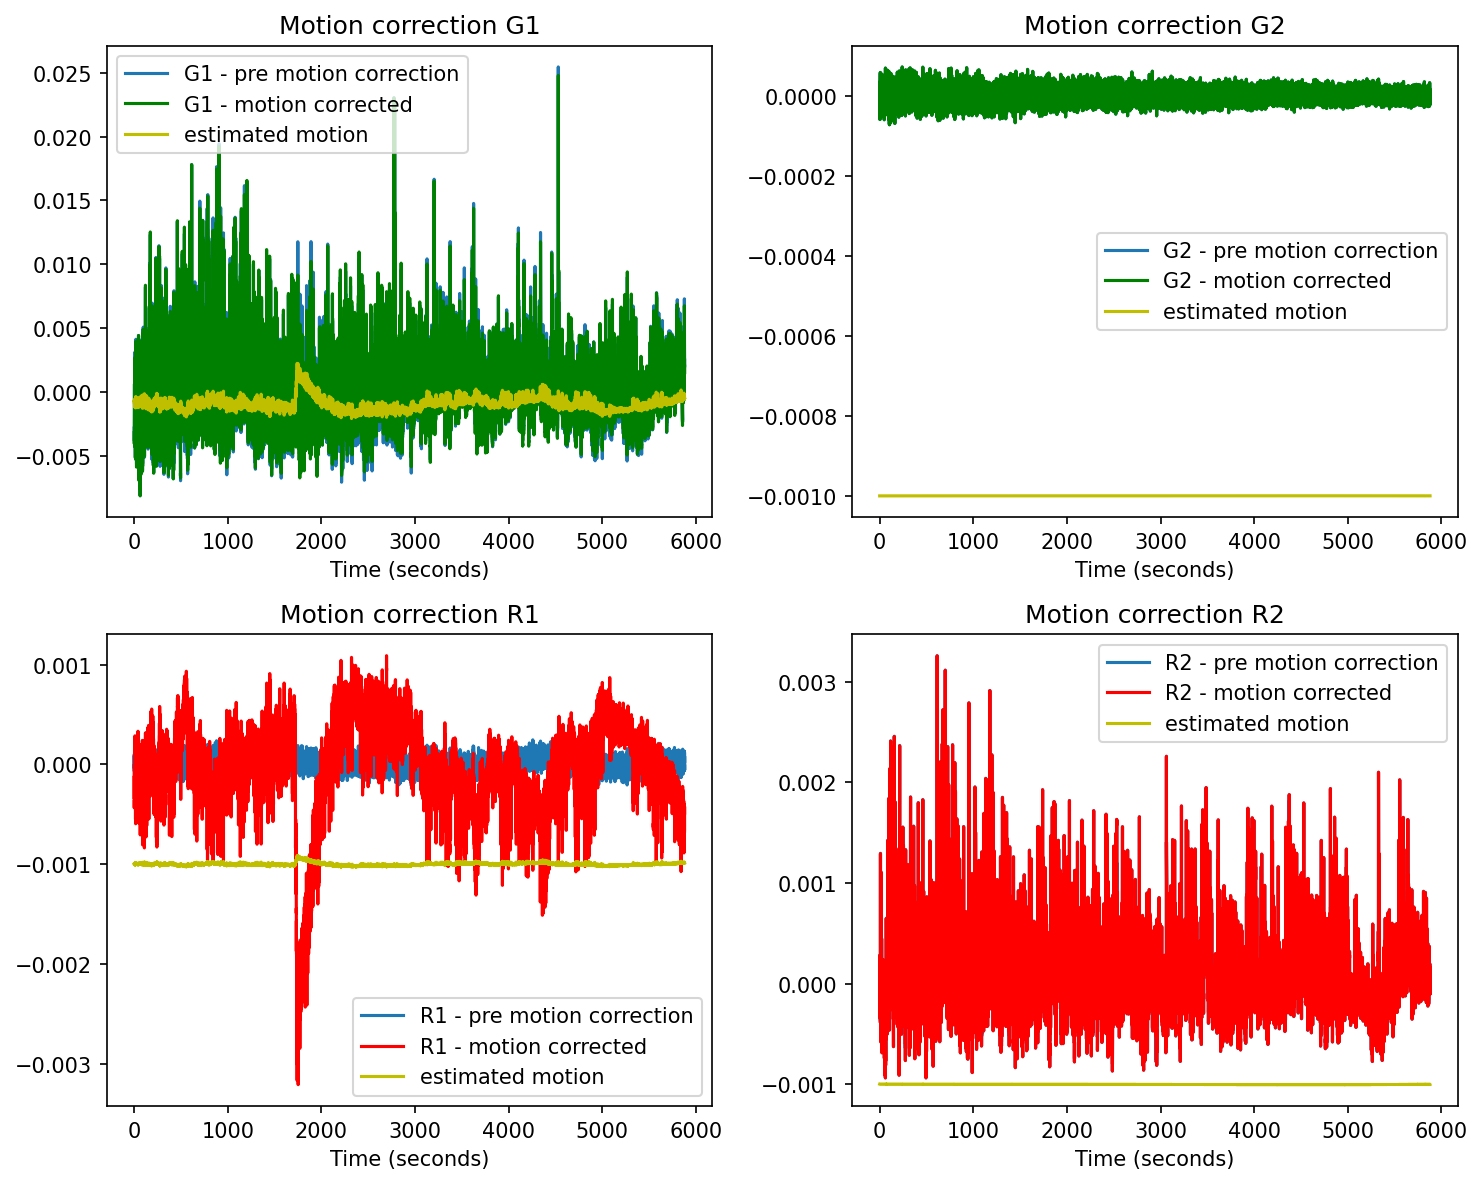

In [34]:
#% motion corrected
G1_est_motion = intercept_G1 + slope_G1 * ctrl1_es
G1_corrected = G1_es - G1_est_motion
G2_est_motion = intercept_G2 + slope_G2 * ctrl2_es
G2_corrected = G2_es - G2_est_motion

R1_est_motion = intercept_R1 + slope_R1 * ctrl1_es
R1_corrected = R1_es - G1_est_motion
R2_est_motion = intercept_R2 + slope_R2 * ctrl2_es
R2_corrected = R2_es - R2_est_motion

plt.figure(figsize=(10, 8), dpi=150)
plt.subplot(2,2,1)
plt.plot(time_seconds, G1_es , label='G1 - pre motion correction')
plt.plot(time_seconds, G1_corrected, 'g', label='G1 - motion corrected')
plt.plot(time_seconds, G1_est_motion - 0.001, 'y', label='estimated motion')
plt.xlabel('Time (seconds)')
plt.title('Motion correction G1')
plt.legend()

plt.subplot(2,2,2)
plt.plot(time_seconds, G2_es , label='G2 - pre motion correction')
plt.plot(time_seconds, G2_corrected, 'g', label='G2 - motion corrected')
plt.plot(time_seconds, G2_est_motion - 0.001, 'y', label='estimated motion')
plt.xlabel('Time (seconds)')
plt.title('Motion correction G2')
plt.legend()

plt.subplot(2,2,3)
plt.plot(time_seconds, R1_es , label='R1 - pre motion correction')
plt.plot(time_seconds, R1_corrected, 'r', label='R1 - motion corrected')
plt.plot(time_seconds, R1_est_motion - 0.001, 'y', label='estimated motion')
plt.xlabel('Time (seconds)')
plt.title('Motion correction R1')
plt.legend()

plt.subplot(2,2,4)
plt.plot(time_seconds, R2_es , label='R2 - pre motion correction')
plt.plot(time_seconds, R2_corrected, 'r', label='R2 - motion corrected')
plt.plot(time_seconds, R2_est_motion - 0.001, 'y', label='estimated motion')
plt.xlabel('Time (seconds)')
plt.title('Motion correction R2')
plt.legend()

plt.tight_layout()

'\nnp.save(AnalDir + os.sep + "G1_dF_F", G1_dF_F)\nnp.save(AnalDir + os.sep + "G2_dF_F", G2_dF_F)\nnp.save(AnalDir + os.sep + "R1_dF_F", R1_dF_F)\nnp.save(AnalDir + os.sep + "R2_dF_F", R2_dF_F)\nnp.save(AnalDir + os.sep + "Ctrl1_dF_F", Ctrl1_dF_F)\nnp.save(AnalDir + os.sep + "Ctrl2_dF_F", Ctrl2_dF_F)\n'

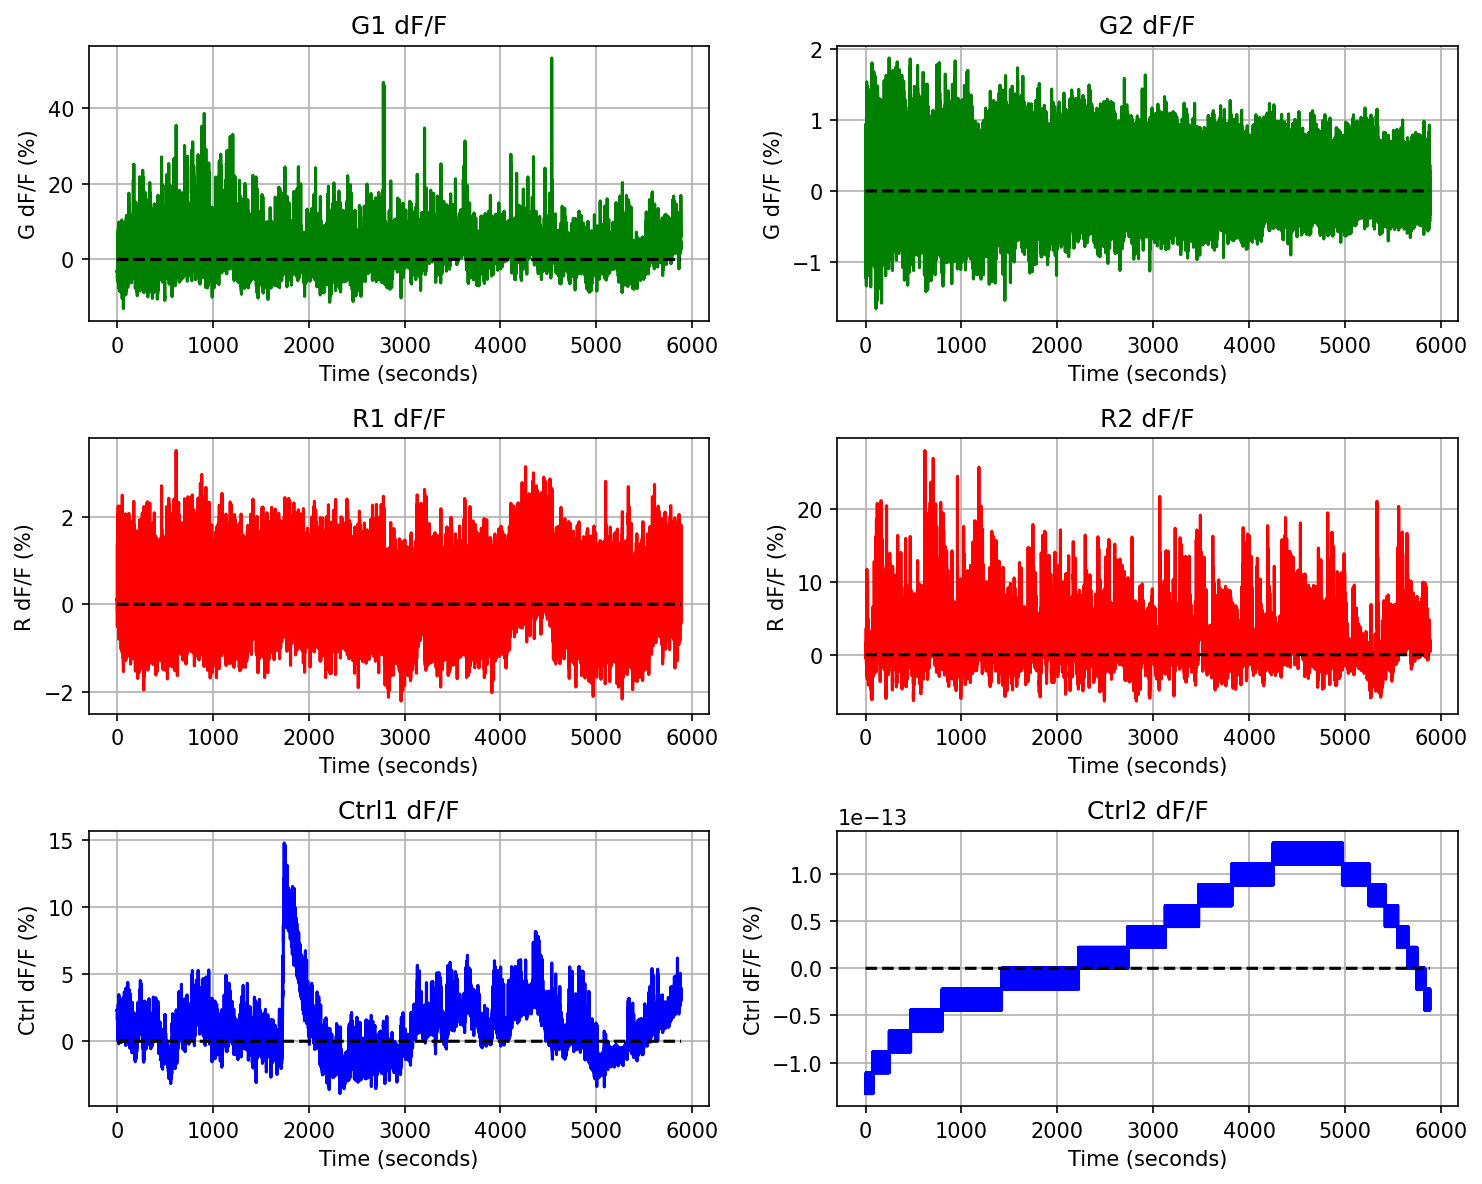

In [35]:
#%% dF/F using sliding baseline
b, a = butter(2, 0.0001, btype='low', fs=sampling_rate)
G1_baseline = filtfilt(b, a, G1_denoised, padtype='even')
G2_baseline = filtfilt(b, a, G2_denoised, padtype='even')
R1_baseline = filtfilt(b, a, R1_denoised, padtype='even')
R2_baseline = filtfilt(b, a, R2_denoised, padtype='even')
ctrl1_baseline = filtfilt(b, a, ctrl1_denoised, padtype='even')
ctrl2_baseline = filtfilt(b, a, ctrl2_denoised, padtype='even')

#G1_dF_F = G1_corrected/G1_baseline
G1_dF_F = G1_es/ G1_baseline
sort = np.sort(G1_dF_F)
b_median = np.median(sort[0:round(len(sort) * b_percentile)])
G1_dF_F = G1_dF_F - b_median

#G2_dF_F = G2_corrected/G2_baseline
G2_dF_F = G2_es/ G2_baseline
sort = np.sort(G2_dF_F)
b_median = np.median(sort[0:round(len(sort) * b_percentile)])
G2_dF_F = G2_dF_F - b_median

#R1_dF_F = R1_corrected/R1_baseline
R1_dF_F = R1_es/ R1_baseline
sort = np.sort(R1_dF_F)
b_median = np.median(sort[0:round(len(sort) * b_percentile)])
R1_dF_F = R1_dF_F - b_median

#R2_dF_F = R2_corrected/R2_baseline
R2_dF_F = R2_es/ R2_baseline
sort = np.sort(R2_dF_F)
b_median = np.median(sort[0:round(len(sort) * b_percentile)])
R2_dF_F = R2_dF_F - b_median

ctrl1_dF_F = ctrl1_es/ ctrl1_baseline
sort = np.sort(ctrl1_dF_F)
b_median = np.median(sort[0:round(len(sort) * b_percentile)])
ctrl1_dF_F = ctrl1_dF_F - b_median

ctrl2_dF_F = ctrl2_es/ ctrl2_baseline
sort = np.sort(ctrl2_dF_F)
b_median = np.median(sort[0:round(len(sort) * b_percentile)])
ctrl2_dF_F = ctrl2_dF_F - b_median


#%%
G1_dF_F = np.append(np.ones([n_frame2cut, 1])*G1_dF_F[0],G1_dF_F)
G2_dF_F = np.append(np.ones([n_frame2cut, 1])*G2_dF_F[0],G2_dF_F)
R1_dF_F = np.append(np.ones([n_frame2cut, 1])*R1_dF_F[0],R1_dF_F)
R2_dF_F = np.append(np.ones([n_frame2cut, 1])*R2_dF_F[0],R2_dF_F)
ctrl1_dF_F = np.append(np.ones([n_frame2cut, 1])*ctrl1_dF_F[0], ctrl1_dF_F)
ctrl2_dF_F = np.append(np.ones([n_frame2cut, 1])*ctrl2_dF_F[0], ctrl2_dF_F)

#%%
time_seconds = np.arange(len(G1_dF_F))/ sampling_rate 

plt.figure(figsize=(10, 8), dpi=150)
plt.subplot(3,2,1)
plt.plot(time_seconds, G1_dF_F*100, 'g')
plt.plot(time_seconds, np.zeros(len(time_seconds)),'--k')
plt.xlabel('Time (seconds)')
plt.ylabel('G dF/F (%)')
plt.title('G1 dF/F')
plt.grid(True)

plt.subplot(3,2,2)
plt.plot(time_seconds, G2_dF_F*100, 'g')
plt.plot(time_seconds, np.zeros(len(time_seconds)),'--k')
plt.xlabel('Time (seconds)')
plt.ylabel('G dF/F (%)')
plt.title('G2 dF/F')
plt.grid(True)

plt.subplot(3,2,3)
plt.plot(time_seconds, R1_dF_F*100, 'r')
plt.plot(time_seconds, np.zeros(len(time_seconds)),'--k')
plt.xlabel('Time (seconds)')
plt.ylabel('R dF/F (%)')
plt.title('R1 dF/F')
plt.grid(True)

plt.subplot(3,2,4)
plt.plot(time_seconds, R2_dF_F*100, 'r')
plt.plot(time_seconds, np.zeros(len(time_seconds)),'--k')
plt.xlabel('Time (seconds)')
plt.ylabel('R dF/F (%)')
plt.title('R2 dF/F')
plt.grid(True)

plt.subplot(3,2,5)
plt.plot(time_seconds, ctrl1_dF_F*100, 'b')
plt.plot(time_seconds, np.zeros(len(time_seconds)),'--k')
plt.xlabel('Time (seconds)')
plt.ylabel('Ctrl dF/F (%)')
plt.title('Ctrl1 dF/F')
plt.grid(True)

plt.subplot(3,2,6)
plt.plot(time_seconds, ctrl2_dF_F*100, 'b')
plt.plot(time_seconds, np.zeros(len(time_seconds)),'--k')
plt.xlabel('Time (seconds)')
plt.ylabel('Ctrl dF/F (%)')
plt.title('Ctrl2 dF/F')
plt.grid(True)
plt.tight_layout()

In [40]:
#%% Save
np.save(os.path.join(result_dir, 'G1_dF_F'), G1_dF_F)
np.save(os.path.join(result_dir, 'G2_dF_F'), G2_dF_F)
np.save(os.path.join(result_dir, 'R1_dF_F'), R1_dF_F)
np.save(os.path.join(result_dir, 'R2_dF_F'), R2_dF_F)
np.save(os.path.join(result_dir, 'ctrl1_dF_F'), ctrl1_dF_F)
np.save(os.path.join(result_dir, 'ctrl2_dF_F'), ctrl2_dF_F)